# Exploring Moscow neighbourhoods with foursquare API

## importing libraries

In [1]:
import copy
import numpy as np
import pandas as pd
import random
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import scipy.stats as stats
import sklearn as skl
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Hello pumpkin world!')

Hello pumpkin world!


In [2]:
!pip install beautifulsoup4

In [3]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

In [4]:
import json # library to handle JSON files

!pip install geopy
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 102kB 5.0MB/s 
Libraries imported.


## Data importing

In [6]:
wikiurl = requests.get('https://en.wikipedia.org/wiki/Category:Districts_of_Moscow').text 
soup = BeautifulSoup(wikiurl, 'lxml')

In [7]:
mwcg = soup.find_all(class_ = "mw-category-group")

csv_file = open('moscow.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

length = len(mwcg) # Gets the length of number of `mw-category-groups` present

for i in range(1, length):  # Gets all the neighbourhoods
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title') # Gets the title of the neighbourhood
        csv_writer.writerow([nbd]) # Writes the name of the neighbourhood in the csv file
csv_file.close()

In [8]:
moscow_dist = pd.read_csv('moscow.csv')

In [9]:
moscow_dist.head(10)

,Neighbourhood
0,Category:Brateyevo District
1,Category:Khamovniki District
2,Category:Matushkino District
3,Category:Meshchansky District
4,Category:Staroye Kryukovo District
5,Category:Tverskoy District
6,Category:Zamoskvorechye District
7,Aeroport District
8,Akademichesky District
9,"Alexeyevsky District, Moscow"


## Clearing the data

In [10]:
moscow_dist = moscow_dist.loc[7:]

In [11]:
moscow_dist.head(10)

,Neighbourhood
7,Aeroport District
8,Akademichesky District
9,"Alexeyevsky District, Moscow"
10,Altufyevsky District
11,"Babushkinsky District, Moscow"
12,Basmanny District
13,Begovoy District
14,Beskudnikovsky District
15,Bibirevo District
16,Biryulyovo Vostochnoye District


In [12]:
moscow_dist.shape

(121, 1)

In [13]:
for i in moscow_dist['Neighbourhood']:
    if i[-8::] != ', Moscow':
        moscow_dist['Neighbourhood'].replace([i], i+', Moscow', inplace=True)
moscow_dist.head(10)

,Neighbourhood
7,"Aeroport District, Moscow"
8,"Akademichesky District, Moscow"
9,"Alexeyevsky District, Moscow"
10,"Altufyevsky District, Moscow"
11,"Babushkinsky District, Moscow"
12,"Basmanny District, Moscow"
13,"Begovoy District, Moscow"
14,"Beskudnikovsky District, Moscow"
15,"Bibirevo District, Moscow"
16,"Biryulyovo Vostochnoye District, Moscow"


In [14]:
moscow_dist.info

<bound method DataFrame.info of                                     Neighbourhood
7                       Aeroport District, Moscow
8                  Akademichesky District, Moscow
9                    Alexeyevsky District, Moscow
10                   Altufyevsky District, Moscow
11                  Babushkinsky District, Moscow
12                      Basmanny District, Moscow
13                       Begovoy District, Moscow
14                Beskudnikovsky District, Moscow
15                      Bibirevo District, Moscow
16        Biryulyovo Vostochnoye District, Moscow
17          Biryulyovo Zapadnoye District, Moscow
18                  Bogorodskoye District, Moscow
19                      Businovo District, Moscow
20                      Butyrsky District, Moscow
21          Chertanovo Severnoye District, Moscow
22       Chertanovo Tsentralnoye District, Moscow
23           Chertanovo Yuzhnoye District, Moscow
24                  Cheryomushki District, Moscow
25                

In [15]:
len(moscow_dist['Neighbourhood'].unique())

121

In [16]:
moscow_dist.describe()

,Neighbourhood
count,121
unique,121
top,"Voykovsky District, Moscow"
freq,1


In [17]:
moscow_dist.sort_values('Neighbourhood',inplace=True)
moscow_dist.head(20)

,Neighbourhood
7,"Aeroport District, Moscow"
8,"Akademichesky District, Moscow"
9,"Alexeyevsky District, Moscow"
10,"Altufyevsky District, Moscow"
11,"Babushkinsky District, Moscow"
12,"Basmanny District, Moscow"
13,"Begovoy District, Moscow"
14,"Beskudnikovsky District, Moscow"
15,"Bibirevo District, Moscow"
16,"Biryulyovo Vostochnoye District, Moscow"


In [18]:
moscow_dist.drop_duplicates(inplace=True)
moscow_dist.describe()

,Neighbourhood
count,121
unique,121
top,"Voykovsky District, Moscow"
freq,1


In [19]:
moscow_dist.reset_index(drop=True, inplace=True)
moscow_dist.head(10)

,Neighbourhood
0,"Aeroport District, Moscow"
1,"Akademichesky District, Moscow"
2,"Alexeyevsky District, Moscow"
3,"Altufyevsky District, Moscow"
4,"Babushkinsky District, Moscow"
5,"Basmanny District, Moscow"
6,"Begovoy District, Moscow"
7,"Beskudnikovsky District, Moscow"
8,"Bibirevo District, Moscow"
9,"Biryulyovo Vostochnoye District, Moscow"


In [20]:
moscow_dist.shape

(121, 1)

## importing location data

In [21]:
lat = []
lng = []
lat_lng_coords = None

In [22]:
neighbourhoods = moscow_dist['Neighbourhood']

In [23]:
# Initialize variables
lat = []
lng = []
lat_lng_coords = None

# getting postcodes from neighbourhoods table
neighbourhoods = moscow_dist['Neighbourhood']

# store latitude and longitude values in lat and lng
for nh in neighbourhoods:
    g = geocoder.arcgis('{}, Moscow, RU'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [24]:
moscow_data = moscow_dist
moscow_data['Latitude'] = lat
moscow_data['Longitude'] = lng

In [25]:
# getting Moscow coordinates
address = 'Moscow'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('latitude:', latitude)
print('longitude:', longitude)

latitude: 55.7504461
longitude: 37.6174943


In [26]:
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood in zip(moscow_data['Latitude'], moscow_data['Longitude'], moscow_data['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

In [27]:
moscow_data.head(20)

,Neighbourhood,Latitude,Longitude
0,"Aeroport District, Moscow",55.81002,37.53677
1,"Akademichesky District, Moscow",55.67862,37.58189
2,"Alexeyevsky District, Moscow",55.75696,37.61502
3,"Altufyevsky District, Moscow",55.88007,37.58305
4,"Babushkinsky District, Moscow",55.86833,37.66389
5,"Basmanny District, Moscow",55.77565,37.67087
6,"Begovoy District, Moscow",55.80761,37.53838
7,"Beskudnikovsky District, Moscow",55.86833,37.54779
8,"Bibirevo District, Moscow",55.88860,37.59650
9,"Biryulyovo Vostochnoye District, Moscow",55.59059,37.67328


In [28]:
moscow_data.describe(include='all')

,Neighbourhood,Latitude,Longitude
count,121,121.000000,121.00000
unique,121,NaN,NaN
top,"Voykovsky District, Moscow",NaN,NaN
freq,1,NaN,NaN
mean,NaN,55.746324,37.58126
std,NaN,0.126669,0.16531
min,NaN,55.171390,37.03609
25%,NaN,55.672110,37.49604
50%,NaN,55.751610,37.58305
75%,NaN,55.828210,37.69476


In [29]:
moscow_data.to_csv('moscow_data.csv')

In [30]:
moscow_fin = pd.read_csv('moscow_data.csv')

In [31]:
moscow_fin.head(10)

,Unnamed: 0,Neighbourhood,Latitude,Longitude
0,0,"Aeroport District, Moscow",55.81002,37.53677
1,1,"Akademichesky District, Moscow",55.67862,37.58189
2,2,"Alexeyevsky District, Moscow",55.75696,37.61502
3,3,"Altufyevsky District, Moscow",55.88007,37.58305
4,4,"Babushkinsky District, Moscow",55.86833,37.66389
5,5,"Basmanny District, Moscow",55.77565,37.67087
6,6,"Begovoy District, Moscow",55.80761,37.53838
7,7,"Beskudnikovsky District, Moscow",55.86833,37.54779
8,8,"Bibirevo District, Moscow",55.88860,37.59650
9,9,"Biryulyovo Vostochnoye District, Moscow",55.59059,37.67328


## Making foursquare API reqests

In [32]:
CLIENT_ID = 'YQRLODNOAXRUXVVNKIPRKZNKKTNGQC3C4R2ZYR0OWU52S0YL' # your Foursquare ID
CLIENT_SECRET = 'ZP2QHHPPXMUNQPWW5SO1IMGPBORFU1ZA2ESJGZFVQMCAO3Y0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YQRLODNOAXRUXVVNKIPRKZNKKTNGQC3C4R2ZYR0OWU52S0YL
CLIENT_SECRET:ZP2QHHPPXMUNQPWW5SO1IMGPBORFU1ZA2ESJGZFVQMCAO3Y0


In [33]:
# creating a function that repeats the same process to all the neighborhoods in Moscow
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
# dataframe that contains Moscow venues
moscow_venues = getNearbyVenues(names=moscow_fin['Neighbourhood'],
                                   latitudes=moscow_data['Latitude'],
                                   longitudes=moscow_data['Longitude']
                                  )

Aeroport District, Moscow
Akademichesky District, Moscow
Alexeyevsky District, Moscow
Altufyevsky District, Moscow
Babushkinsky District, Moscow
Basmanny District, Moscow
Begovoy District, Moscow
Beskudnikovsky District, Moscow
Bibirevo District, Moscow
Biryulyovo Vostochnoye District, Moscow
Biryulyovo Zapadnoye District, Moscow
Bogorodskoye District, Moscow
Businovo District, Moscow
Butyrsky District, Moscow
Chertanovo Severnoye District, Moscow
Chertanovo Tsentralnoye District, Moscow
Chertanovo Yuzhnoye District, Moscow
Cheryomushki District, Moscow
Danilovsky District, Moscow
Dmitrovsky District, Moscow
Donskoy District, Moscow
Dorogomilovo District, Moscow
Fili-Davydkovo District, Moscow
Filyovsky Park District, Moscow
Gagarinsky District, Moscow
Golovinsky District, Moscow
Golyanovo District, Moscow
Ivanovskoye District, Moscow
Izmaylovo District, Moscow
Kapotnya District, Moscow
Khoroshyovo-Mnyovniki District, Moscow
Khoroshyovsky District, Moscow
Khovrino District, Moscow
Konk

In [35]:
moscow_venues.to_csv('moscow_venues.csv')

In [36]:
print(moscow_venues.shape)
moscow_venues.head()

(2167, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Aeroport District, Moscow",55.81002,37.53677,Отдохни,55.805900,37.536928,Liquor Store
1,"Aeroport District, Moscow",55.81002,37.53677,Во Дворе,55.807799,37.534298,Dog Run
2,"Aeroport District, Moscow",55.81002,37.53677,"Антикафе ""Часовая""",55.808262,37.532661,Café
3,"Aeroport District, Moscow",55.81002,37.53677,Вкуснота,55.808403,37.530171,Bistro
4,"Aeroport District, Moscow",55.81002,37.53677,Хинкальная,55.807821,37.530003,Dumpling Restaurant


In [37]:
# checking how many venues were returned for each neighborhood
moscow_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Aeroport District, Moscow",14,14,14,14,14,14
"Akademichesky District, Moscow",15,15,15,15,15,15
"Alexeyevsky District, Moscow",98,98,98,98,98,98
"Altufyevsky District, Moscow",19,19,19,19,19,19
"Babushkinsky District, Moscow",29,29,29,29,29,29
"Basmanny District, Moscow",68,68,68,68,68,68
"Begovoy District, Moscow",21,21,21,21,21,21
"Beskudnikovsky District, Moscow",8,8,8,8,8,8
"Bibirevo District, Moscow",28,28,28,28,28,28


In [38]:
print('There are {} uniques categories.'.format(len(moscow_venues['Venue Category'].unique())))

There are 272 uniques categories.


In [39]:
# one hot encoding
moscow_onehot = pd.get_dummies(moscow_venues['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
moscow_onehot['Neighbourhood'] = moscow_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [moscow_onehot.columns[-1]] + moscow_onehot.columns[:-1].to_list()
moscow_onehot = moscow_onehot[fixed_columns]

moscow_onehot.head()

<class 'pandas.core.indexes.base.Index'>
<class 'bs4.element.ResultSet'>


,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Basketball Court,Bath House,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Line,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caucasian Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dive Bar,Dive Spot,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Notary,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,RV Park,Racetrack,Record Shop,Recording Studio,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Train,Train Station,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Waterfall,Waterfront,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Aeroport District, Moscow",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [40]:
moscow_onehot.shape

(2167, 273)

In [41]:
moscow_grouped = moscow_onehot.groupby('Neighbourhood').mean().reset_index()
moscow_grouped

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Basketball Court,Bath House,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Line,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caucasian Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dive Bar,Dive Spot,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Notary,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,RV Park,Racetrack,Record Shop,Recording Studio,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Train,Train Station,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Waterfall,Waterfront,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Aeroport District, Moscow",0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.0000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.

In [42]:
moscow_grouped.shape

(120, 273)

In [43]:
num_top_venues = 5

for hood in moscow_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = moscow_grouped[moscow_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aeroport District, Moscow----
               venue  freq
0  Food & Drink Shop  0.14
1       Liquor Store  0.07
2           Bus Stop  0.07
3               Café  0.07
4             Bistro  0.07


----Akademichesky District, Moscow----
                   venue  freq
0      Convenience Store  0.13
1            Pizza Place  0.07
2  Vietnamese Restaurant  0.07
3               Bus Stop  0.07
4   Gym / Fitness Center  0.07


----Alexeyevsky District, Moscow----
            venue  freq
0        Boutique  0.06
1         Theater  0.05
2   Historic Site  0.05
3     Coffee Shop  0.05
4  Cosmetics Shop  0.05


----Altufyevsky District, Moscow----
           venue  freq
0    Supermarket  0.26
1       Building  0.05
2  Grocery Store  0.05
3     Beer Store  0.05
4       Bus Line  0.05


----Babushkinsky District, Moscow----
               venue  freq
0           Pharmacy  0.07
1  Food & Drink Shop  0.07
2        Supermarket  0.07
3     Cosmetics Shop  0.07
4   Sushi Restaurant  0.03


----Basmanny 

In [44]:
# creating a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
# creating new dataframe which displays the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = moscow_grouped['Neighbourhood']

for ind in np.arange(moscow_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(moscow_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",Food & Drink Shop,Dog Run,Gym / Fitness Center,Fruit & Vegetable Store,Betting Shop,Train Station,Café,Pizza Place,Bistro,Bus Stop
1,"Akademichesky District, Moscow",Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Caucasian Restaurant,Health & Beauty Service,Food & Drink Shop,Café,Museum,Pizza Place,Chinese Restaurant
2,"Alexeyevsky District, Moscow",Boutique,Coffee Shop,Historic Site,Cosmetics Shop,Theater,Shoe Store,Fountain,Hotel,Italian Restaurant,Russian Restaurant
3,"Altufyevsky District, Moscow",Supermarket,Grocery Store,Health Food Store,Pharmacy,Convenience Store,Food & Drink Shop,Gym Pool,Salon / Barbershop,Café,Bus Stop
4,"Babushkinsky District, Moscow",Pharmacy,Food & Drink Shop,Cosmetics Shop,Supermarket,Kids Store,Café,Mobile Phone Shop,Gym,Blini House,Sushi Restaurant


## Kmeans clustering

In [46]:
# set number of clusters
kclusters = 5

moscow_grouped_clustering = moscow_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

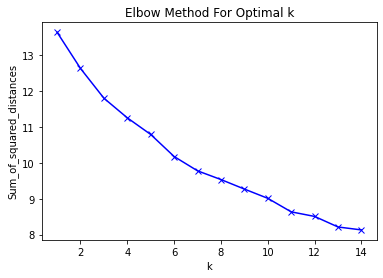

In [47]:
# finding optimal k number
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(moscow_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

# plotting the graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
# set number of clusters
kclusters = 6

moscow_grouped_clustering = moscow_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 5, 5, 1, 5, 5, 5, 5, 5, 1], dtype=int32)

In [49]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

moscow_merged = moscow_data

# merge moscow_grouped with moscow_data to add latitude/longitude for each neighborhood
moscow_merged = moscow_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

moscow_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",55.81002,37.53677,5.0,Food & Drink Shop,Dog Run,Gym / Fitness Center,Fruit & Vegetable Store,Betting Shop,Train Station,Café,Pizza Place,Bistro,Bus Stop
1,"Akademichesky District, Moscow",55.67862,37.58189,5.0,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Caucasian Restaurant,Health & Beauty Service,Food & Drink Shop,Café,Museum,Pizza Place,Chinese Restaurant
2,"Alexeyevsky District, Moscow",55.75696,37.61502,5.0,Boutique,Coffee Shop,Historic Site,Cosmetics Shop,Theater,Shoe Store,Fountain,Hotel,Italian Restaurant,Russian Restaurant
3,"Altufyevsky District, Moscow",55.88007,37.58305,1.0,Supermarket,Grocery Store,Health Food Store,Pharmacy,Convenience Store,Food & Drink Shop,Gym Pool,Salon / Barbershop,Café,Bus Stop
4,"Babushkinsky District, Moscow",55.86833,37.66389,5.0,Pharmacy,Food & Drink Shop,Cosmetics Shop,Supermarket,Kids Store,Café,Mobile Phone Shop,Gym,Blini House,Sushi Restaurant


In [50]:
moscow_merged.dropna(inplace=True)
moscow_merged.reset_index(drop=True, inplace=True)

In [51]:
moscow_merged = moscow_merged.astype({'Cluster Labels': int})
moscow_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",55.81002,37.53677,5,Food & Drink Shop,Dog Run,Gym / Fitness Center,Fruit & Vegetable Store,Betting Shop,Train Station,Café,Pizza Place,Bistro,Bus Stop
1,"Akademichesky District, Moscow",55.67862,37.58189,5,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Caucasian Restaurant,Health & Beauty Service,Food & Drink Shop,Café,Museum,Pizza Place,Chinese Restaurant
2,"Alexeyevsky District, Moscow",55.75696,37.61502,5,Boutique,Coffee Shop,Historic Site,Cosmetics Shop,Theater,Shoe Store,Fountain,Hotel,Italian Restaurant,Russian Restaurant
3,"Altufyevsky District, Moscow",55.88007,37.58305,1,Supermarket,Grocery Store,Health Food Store,Pharmacy,Convenience Store,Food & Drink Shop,Gym Pool,Salon / Barbershop,Café,Bus Stop
4,"Babushkinsky District, Moscow",55.86833,37.66389,5,Pharmacy,Food & Drink Shop,Cosmetics Shop,Supermarket,Kids Store,Café,Mobile Phone Shop,Gym,Blini House,Sushi Restaurant


# Plotting results

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_merged['Latitude'], moscow_merged['Longitude'], moscow_merged['Neighbourhood'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [79]:
# forming resulting dataframe
moscow_res = pd.DataFrame()
moscow_res['Neighbourhood'] = moscow_merged['Neighbourhood']
moscow_res['Cluster Labels'] = moscow_merged['Cluster Labels']

for i in range(3, 14):
    moscow_res[moscow_merged.columns[i]] = moscow_merged[moscow_merged.columns[i]]

moscow_res.head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",5,Food & Drink Shop,Dog Run,Gym / Fitness Center,Fruit & Vegetable Store,Betting Shop,Train Station,Café,Pizza Place,Bistro,Bus Stop
1,"Akademichesky District, Moscow",5,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Caucasian Restaurant,Health & Beauty Service,Food & Drink Shop,Café,Museum,Pizza Place,Chinese Restaurant
2,"Alexeyevsky District, Moscow",5,Boutique,Coffee Shop,Historic Site,Cosmetics Shop,Theater,Shoe Store,Fountain,Hotel,Italian Restaurant,Russian Restaurant
3,"Altufyevsky District, Moscow",1,Supermarket,Grocery Store,Health Food Store,Pharmacy,Convenience Store,Food & Drink Shop,Gym Pool,Salon / Barbershop,Café,Bus Stop
4,"Babushkinsky District, Moscow",5,Pharmacy,Food & Drink Shop,Cosmetics Shop,Supermarket,Kids Store,Café,Mobile Phone Shop,Gym,Blini House,Sushi Restaurant


# Taking a look to each cluster

In [103]:
# Cluster Num 0
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 0].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 0].head(10)

Number of districts: 1


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,"Tsaritsyno District, Moscow",0,Supermarket,Zoo Exhibit,Gaming Cafe,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden


In [104]:
# Cluster Num 1
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 1].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 1].head(10)

Number of districts: 38


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Altufyevsky District, Moscow",1,Supermarket,Grocery Store,Health Food Store,Pharmacy,Convenience Store,Food & Drink Shop,Gym Pool,Salon / Barbershop,Café,Bus Stop
9,"Biryulyovo Vostochnoye District, Moscow",1,Supermarket,Park,Athletics & Sports,Bus Line,Nightclub,Gym / Fitness Center,Beer Store,Zoo Exhibit,Field,Fruit & Vegetable Store
10,"Biryulyovo Zapadnoye District, Moscow",1,Bus Stop,Pool,Supermarket,Hockey Rink,Park,Shoe Store,Italian Restaurant,Garden,Gaming Cafe,Garden Center
11,"Bogorodskoye District, Moscow",1,Supermarket,Pharmacy,Eastern European Restaurant,Tram Station,Health Food Store,Dance Studio,Gym / Fitness Center,Fruit & Vegetable Store,Fountain,French Restaurant
13,"Butyrsky District, Moscow",1,Park,Coffee Shop,Historic Site,Music Venue,Auto Workshop,Health & Beauty Service,Zoo Exhibit,Furniture / Home Store,Fried Chicken Joint,Frozen Yogurt Shop
16,"Chertanovo Yuzhnoye District, Moscow",1,Supermarket,Convenience Store,Bus Stop,Farmers Market,Flea Market,Auto Workshop,Shopping Mall,Fruit & Vegetable Store,Train Station,Nightclub
24,"Golovinsky District, Moscow",1,Auto Workshop,Supermarket,Pizza Place,Convenience Store,Brewery,Gym Pool,Pet Store,Food & Drink Shop,Waterfall,Fast Food Restaurant
26,"Ivanovskoye District, Moscow",1,Supplement Shop,Grocery Store,Museum,Park,Gay Bar,Gelato Shop,Gastropub,Garden Center,Garden,Gift Shop
28,"Kapotnya District, Moscow",1,Middle Eastern Restaurant,Lake,Park,Café,Furniture / Home Store,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store
31,"Khovrino District, Moscow",1,Supermarket,Auto Workshop,Pizza Place,Café,Salon / Barbershop,Bus Line,Sushi Restaurant,Grocery Store,Taxi Stand,Gym / Fitness Center


In [105]:
# Cluster Num 2
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 2].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 2].head(10)

Number of districts: 1


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,"Perovo District, Moscow",2,Lighthouse,Zoo Exhibit,Gaming Cafe,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden


In [106]:
# Cluster Num 3
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 3].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 3].head(10)

Number of districts: 1


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
104,"Vnukovo District, Moscow",3,Soccer Field,Basketball Court,Zoo Exhibit,Furniture / Home Store,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Gaming Cafe


In [107]:
# Cluster Num 4
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 4].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 4].head(10)

Number of districts: 8


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Businovo District, Moscow",4,Supermarket,Pool,Bus Stop,Skate Park,Gastropub,Garden Center,Garden,Gaming Cafe,Gay Bar,Food Court
25,"Golyanovo District, Moscow",4,Bus Stop,Toy / Game Store,Bike Trail,Shoe Store,Shopping Mall,Supermarket,Bus Line,Lake,Park,Liquor Store
52,"Metrogorodok District, Moscow",4,Bus Stop,Tram Station,Food & Drink Shop,Supermarket,Gelato Shop,Gay Bar,Gastropub,Garden Center,Garden,Gaming Cafe
54,"Molzhaninovsky District, Moscow",4,Bus Stop,Taco Place,Armenian Restaurant,Burger Joint,Athletics & Sports,Garden,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store
60,"Nekrasovka District, Moscow",4,Bus Stop,Flower Shop,Moving Target,Gaming Cafe,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Zoo Exhibit,Fountain
62,"Novo-Peredelkino District, Moscow",4,Bus Stop,Supermarket,Eastern European Restaurant,Sushi Restaurant,Grocery Store,Auto Workshop,Garden,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store
80,"Savyolki District, Moscow",4,Bus Stop,Pizza Place,Restaurant,Automotive Shop,Pharmacy,Park,Sporting Goods Shop,Gourmet Shop,Theater,Health Food Store
92,"Solntsevo District, Moscow",4,Bus Stop,Cafeteria,Other Great Outdoors,Art Gallery,Cosmetics Shop,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe


In [108]:
# Cluster Num 5
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 5].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 5].head(10)

Number of districts: 71


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",5,Food & Drink Shop,Dog Run,Gym / Fitness Center,Fruit & Vegetable Store,Betting Shop,Train Station,Café,Pizza Place,Bistro,Bus Stop
1,"Akademichesky District, Moscow",5,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Caucasian Restaurant,Health & Beauty Service,Food & Drink Shop,Café,Museum,Pizza Place,Chinese Restaurant
2,"Alexeyevsky District, Moscow",5,Boutique,Coffee Shop,Historic Site,Cosmetics Shop,Theater,Shoe Store,Fountain,Hotel,Italian Restaurant,Russian Restaurant
4,"Babushkinsky District, Moscow",5,Pharmacy,Food & Drink Shop,Cosmetics Shop,Supermarket,Kids Store,Café,Mobile Phone Shop,Gym,Blini House,Sushi Restaurant
5,"Basmanny District, Moscow",5,Coffee Shop,Recording Studio,Hookah Bar,Caucasian Restaurant,Dance Studio,Café,Hotel,Clothing Store,Park,Pharmacy
6,"Begovoy District, Moscow",5,Food & Drink Shop,Gym / Fitness Center,Auto Workshop,Electronics Store,Bus Stop,Cafeteria,Café,Fruit & Vegetable Store,Health Food Store,Coffee Shop
7,"Beskudnikovsky District, Moscow",5,Food & Drink Shop,Fast Food Restaurant,Pizza Place,Automotive Shop,Plaza,Asian Restaurant,Park,Clothing Store,Garden,Gaming Cafe
8,"Bibirevo District, Moscow",5,Gym / Fitness Center,Pizza Place,Pet Store,Italian Restaurant,Pharmacy,Butcher,Supermarket,Gym,Shipping Store,Clothing Store
14,"Chertanovo Severnoye District, Moscow",5,Gym,Cosmetics Shop,Eastern European Restaurant,Supermarket,Wine Shop,Bookstore,Furniture / Home Store,Soccer Field,Athletics & Sports,Fried Chicken Joint
15,"Chertanovo Tsentralnoye District, Moscow",5,Gym,Cosmetics Shop,Eastern European Restaurant,Supermarket,Wine Shop,Bookstore,Furniture / Home Store,Soccer Field,Athletics & Sports,Fried Chicken Joint


## Reviewing two main clusters

In [109]:
# Living cluster?
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 1].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 1].head(5)

Number of districts: 38


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Altufyevsky District, Moscow",1,Supermarket,Grocery Store,Health Food Store,Pharmacy,Convenience Store,Food & Drink Shop,Gym Pool,Salon / Barbershop,Café,Bus Stop
9,"Biryulyovo Vostochnoye District, Moscow",1,Supermarket,Park,Athletics & Sports,Bus Line,Nightclub,Gym / Fitness Center,Beer Store,Zoo Exhibit,Field,Fruit & Vegetable Store
10,"Biryulyovo Zapadnoye District, Moscow",1,Bus Stop,Pool,Supermarket,Hockey Rink,Park,Shoe Store,Italian Restaurant,Garden,Gaming Cafe,Garden Center
11,"Bogorodskoye District, Moscow",1,Supermarket,Pharmacy,Eastern European Restaurant,Tram Station,Health Food Store,Dance Studio,Gym / Fitness Center,Fruit & Vegetable Store,Fountain,French Restaurant
13,"Butyrsky District, Moscow",1,Park,Coffee Shop,Historic Site,Music Venue,Auto Workshop,Health & Beauty Service,Zoo Exhibit,Furniture / Home Store,Fried Chicken Joint,Frozen Yogurt Shop


In [110]:
# Entertainment cluster?
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 5].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 5].head(5)

Number of districts: 71


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",5,Food & Drink Shop,Dog Run,Gym / Fitness Center,Fruit & Vegetable Store,Betting Shop,Train Station,Café,Pizza Place,Bistro,Bus Stop
1,"Akademichesky District, Moscow",5,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Caucasian Restaurant,Health & Beauty Service,Food & Drink Shop,Café,Museum,Pizza Place,Chinese Restaurant
2,"Alexeyevsky District, Moscow",5,Boutique,Coffee Shop,Historic Site,Cosmetics Shop,Theater,Shoe Store,Fountain,Hotel,Italian Restaurant,Russian Restaurant
4,"Babushkinsky District, Moscow",5,Pharmacy,Food & Drink Shop,Cosmetics Shop,Supermarket,Kids Store,Café,Mobile Phone Shop,Gym,Blini House,Sushi Restaurant
5,"Basmanny District, Moscow",5,Coffee Shop,Recording Studio,Hookah Bar,Caucasian Restaurant,Dance Studio,Café,Hotel,Clothing Store,Park,Pharmacy


# (OwO)